# Lab 8 - Aspect-Based Sentiment Analysis with BERT

In this lab we turn a pre-trained BERT model into a trainable Keras layer and apply it to the Aspect-Based Sentiment Analysis that we tackled in lab 4. BERT (Bidirectional Embedding Representations from Transformers) is a new model for pre-training language representations that obtains state-of-the-art results on many NLP tasks. We demonstrate how to integrate BERT as a custom Keras layer to simplify model prototyping using huggingface. In this lab, you will learn: 

1) How to use the huggingface package.

2) How to integrate BERT in our previous model. 

3) How to use the TPU from Colab. (Note: Running BERT on the CPU would be very slow. Thus we recommend you to do this lab on Colab based on TPU provided by Google.)

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model


Before start, we should install the huggingface transformer package. You can find the doc from its [website](https://huggingface.co/transformers/index.html).

In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 5.6 MB/s 
     |████████████████████████████████| 596 kB 31.2 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 6.6 MB 9.1 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Preprocessing and Tokenization

In this lab we will use DistilBERT instead of BERT: DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, and runs 60% faster, while preserving over 95% of BERT’s performance as measured on the GLUE language understanding benchmark.

It is easy to switch between DistilBERT and BERT using the huggingface transformer package. This huggingface package provides many pre-trained and pre-built models that are easy to use via a few lines of code.

Before using DistilBERT or BERT, we need a tokenizer. Generally speaking, every BERT related model has its own tokenizer, trained for that model (see this week's lecture video on sub-word tokenization). 
We can get the DistilBERT tokenizer from **DistilBertTokenizer.from_pretrained** function.

In [ ]:
from transformers import DistilBertTokenizer, RobertaTokenizer 
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Then we can use the tokenizer to tokenize the sentence. When working with word2vec and GloVe, we tokenized the sentence into words ourselves and then converted the tokens to GloVe word indices. But in BERT, we must use the BERT tokenizer: the tokens for BERT are different, and include whole words and sub-word tokens (see lecture video on sub-word tokenisation).

For example, for the sentence: **This is a pretrained model.** our previous word-based tokenizer will generate the following tokens:

**"this", "is", "a", "pretrained", "model", "."**

Then you will find out that the word token "pretrained" is not in the GloVe word dictionary. Thus we can not assign a proper word vector for "pretrained".

In BERT, the BERT tokenizer will separate the word "pretrained" into three sub-word tokens:

**'pre', '##train', '##ed'**

This way, BERT can use these three token vectors to represent the word "pretrained". Without the BERT tokenizer, it is hard to separate these unknown words properly.

You will also see that the BERT tokenizer adds the special sentence [CLS] token and sentence separator [SEP] tokens (see this week's lecture videos).

In [ ]:
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')

inputs = tokenizer.tokenize("This is a pretrained model.")
print(inputs,'\n')

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, pad_to_max_length=False)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

['this', 'is', 'a', 'pre', '##train', '##ed', 'model', '.'] 

[ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Loading Data

### Downloading and preprocessing data

Similar to lab 4, we need to download and preprocess the data first. The data download code is consistent with lab 4.

In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
dev = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))


Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("SENTENCE \t ASPECT \t LABLE \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABLE 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


Creating a function that extracts ids and masks for both the aspects and reviews

In [ ]:
def extract_ids_masks(data):
  x_train_review_int = []
  x_train_review_mask = []
  x_train_aspect_int = []
  x_train_aspect_mask = []
  for sents in data:
    ids_r,masks_r,segments_r = tokenize(sents[0], tokenizer)
    x_train_review_int.append(ids_r)
    x_train_review_mask.append(masks_r)
    # same for aspect

    ids_a,masks_a,segments_a = tokenize(sents[1], tokenizer)
    x_train_aspect_int.append(ids_a)
    x_train_aspect_mask.append(masks_a)
  
  return   x_train_review_int, x_train_review_mask, x_train_aspect_int, x_train_aspect_mask


According to the BERT tokenize function above, we can convert the tweet text and topic words to integers:

(Note: the BERT tokenize function is different from lab 4.)


In [ ]:
# Please write your code to generate the following data

# calling the above created function to extract ids and masks (both aspect and reviews) for train, dev and test datasets.
x_train_review_int, x_train_review_masks, x_train_aspect_int, x_train_aspect_masks = extract_ids_masks(train)

x_dev_review_int, x_dev_review_masks, x_dev_aspect_int, x_dev_aspect_masks = extract_ids_masks(dev)

x_test_review_int, x_test_review_masks, x_test_aspect_int, x_test_aspect_masks = extract_ids_masks(test)

# If use the previous tokenize function, you can get a print result like:
assert len(x_train_aspect_int) == len(train)
assert len(x_train_aspect_masks) == len(x_train_aspect_int)
assert len(x_test_aspect_int) == len(test)
assert len(x_test_aspect_masks) == len(x_test_aspect_int)
print("x_dev_aspect_int[0]:")
print(x_dev_aspect_int[0])
print("x_dev_aspect_masks[0]:")
print(x_dev_aspect_masks[0])
print("x_dev_review_int[0]:")
print(x_dev_review_int[0])
print("x_dev_review_masks[0]:")
print(x_dev_review_masks[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


x_dev_aspect_int[0]:
[ 101 8974  102    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
x_dev_aspect_masks[0]:
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_dev_review_int[0]:
[  101  2044  1037  323

We one-hot encode the labels, using 4 (Binary:100) to represent "positive", 2 (Binary:010) for "neutral", and 1 (Binary:001) for "negative". Then we can convert the labels to numbers.

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(dev)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


In [ ]:
# creating a function to join the tweet with respective topics
def join_tweet_topic(data):
  x_train_int = []
  x_train_mask = []
  for sents in data:
    ids_r,masks_r,segments_r = tokenize(sents[0] + '[SEP]' + sents[1], tokenizer) # adding a separator in between as mentioned
    x_train_int.append(ids_r)
    x_train_mask.append(masks_r)

  return   x_train_int, x_train_mask


Now we have almost done the data preprocessing. Unlike the previous lab1-lab4, there are two x (review and aspect) to input the model. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

In [ ]:
# Please write your code to combine the tweet and topic into the following varibles

# getting x_train_int and x_train mask using join_tweet_topic funciton that we created 
x_train_int, x_train_masks = join_tweet_topic(train)
x_dev_int, x_dev_masks = join_tweet_topic(dev)
x_test_int, x_test_masks = join_tweet_topic(test)

# Tips: 
# 1) We can use the special token <SEP> to concatenate the tweets and topics.
# 2) After combine them, make sure they are paded.


# Don't forget the to use np.array function to wrap the ouput of pad_sequences function
x_train_int_np = np.array(x_train_int)
x_train_masks_np = np.array(x_train_masks)
x_dev_int_np = np.array(x_dev_int)
x_dev_masks_np = np.array(x_dev_masks)
x_test_int_np = np.array(x_test_int)
x_test_masks_np = np.array(x_test_masks)


print(x_dev_int[0])
print(x_dev_masks[0],'\n')
print(x_dev_int_np[0])
print(x_dev_masks_np[0]) # senetnce + aspect


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[  101  2044  1037  3232  1997  8974  1010  1996 18726  1011  1011  1045
  2066  1996 27940  1013 24792  2621  4897  1998  1996 13675 11514  6508
 26852  1011  1011  2175  2091  2307  1012   102  8974   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Model 1: Prebuilt Sequence Classification



The huggingface transformer package provides many prebuilt models. Now let us try a sequence classification model based on distillBERT. 

The models with BERT are much bigger than our previous models. To run it faster, we can use TPU here. The detailed guideline about using TPU can be found from https://www.tensorflow.org/guide/tpu.

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=3)
config.output_hidden_states = False

def create_TFDistilBertForSequenceClassification():
  transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFDistilBertForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_TFDistilBertForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.179.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.179.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_c

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955779   ['input_token[0][0]',            
 assification_1 (TFDistilBertFo  rOutput(loss=None,               'masked_token[0][0]']           
 rSequenceClassification)       logits=(None, 3),                                                 
                                 hidden_states=None                                         

In [ ]:
history_1 = model.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 109s 3s/step - loss: 0.8468 - accuracy: 0.4247 - val_loss: 0.6072 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 5s 225ms/step - loss: 0.6014 - accuracy: 0.4525 - val_loss: 0.5761 - val_accuracy: 0.4535
Epoch 3/30
22/22 [==============================] - 5s 225ms/step - loss: 0.5741 - accuracy: 0.4757 - val_loss: 0.5681 - val_accuracy: 0.4970
Epoch 4/30
22/22 [==============================] - 5s 225ms/step - loss: 0.5603 - accuracy: 0.5069 - val_loss: 0.5447 - val_accuracy: 0.5338
Epoch 5/30
22/22 [==============================] - 5s 224ms/step - loss: 0.5151 - accuracy: 0.5986 - val_loss: 0.5085 - val_accuracy: 0.6734
Epoch 6/30
22/22 [==============================] - 8s 377ms/step - loss: 0.5294 - accuracy: 0.5920 - val_loss: 0.4983 - val_accuracy: 0.5773
Epoch 7/30
22/22 [==============================] - 5s 250ms/step - loss: 0.4548 - accuracy: 0.6935 - val_loss: 0.4760 - val_accuracy: 0.7402
Epoch 8

In [ ]:
results_1 = model.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results_1)

42/42 [==============================] - 8s 105ms/step - loss: 1.0288 - accuracy: 0.8174
[1.0288443565368652, 0.817365288734436]



## Model 2: Neural bag of words using BERT

We use model3-1 from lab4 to integrate BERT, using BERT instead of the previous static word embeddings.


In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(lr=5e-5)
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary() 

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.179.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.179.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model2_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_2 = model2.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 107s 3s/step - loss: 0.5777 - accuracy: 0.5021 - val_loss: 0.5024 - val_accuracy: 0.6562
Epoch 2/30
22/22 [==============================] - 5s 222ms/step - loss: 0.4626 - accuracy: 0.6885 - val_loss: 0.4159 - val_accuracy: 0.7568
Epoch 3/30
22/22 [==============================] - 5s 223ms/step - loss: 0.3943 - accuracy: 0.7828 - val_loss: 0.3886 - val_accuracy: 0.7973
Epoch 4/30
22/22 [==============================] - 5s 224ms/step - loss: 0.3583 - accuracy: 0.8238 - val_loss: 0.3750 - val_accuracy: 0.8026
Epoch 5/30
22/22 [==============================] - 5s 221ms/step - loss: 0.3302 - accuracy: 0.8635 - val_loss: 0.3698 - val_accuracy: 0.8063
Epoch 6/30
22/22 [==============================] - 5s 228ms/step - loss: 0.3104 - accuracy: 0.8883 - val_loss: 0.3684 - val_accuracy: 0.8123
Epoch 7/30
22/22 [==============================] - 5s 222ms/step - loss: 0.2968 - accuracy: 0.9058 - val_loss: 0.3727 - val_accuracy: 0.8041
Epoch 8

In [ ]:
results_2 = model2.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results_2)

42/42 [==============================] - 9s 110ms/step - loss: 0.3471 - accuracy: 0.8331
[0.34712132811546326, 0.8330838680267334]


In [ ]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9236 sha256=1a24de0875d8699398a765a6ac7b7267a8b9828a4359b3529555e4b800ea9ae1
  Stored in directory: /root/.cache/pip/wheels/ca/73/ed/41022b42c1d9ce60a8a2ebb71f042c7f895673760404d39fd7
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.33-py3-none-any.whl size=8285 sha256=b21c7a104133fc2b33e7a1d789975e926191961f4516ba81b4b3d72004b232f5
  Stored in directory: /root/.cache/pip/wheels/66/ab/57/d00b27746f59b194d2b311d076da744dd3fc1f6ceb8574e9ae
  Created wheel for compress-json: filename=compress_json-1.0.6-py3-none-any.whl size=5180 sha256=880133394d155f390c189a7ae4a72a048d01df075767b536bba4a9588ca0e973
  Stored in directory: /root/.cache/pip/wheels/1a/2c/d0/837324b043742b7f4b2f1e780cd32ceee869c9a2ecf9e7eb93
Successfully built plot-keras-history sanitize-ml-labels compress-json


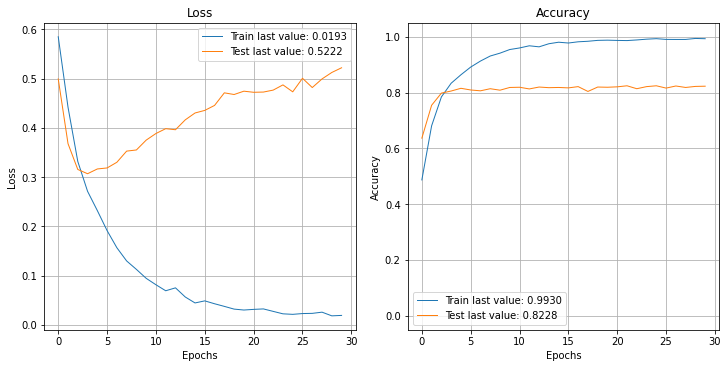

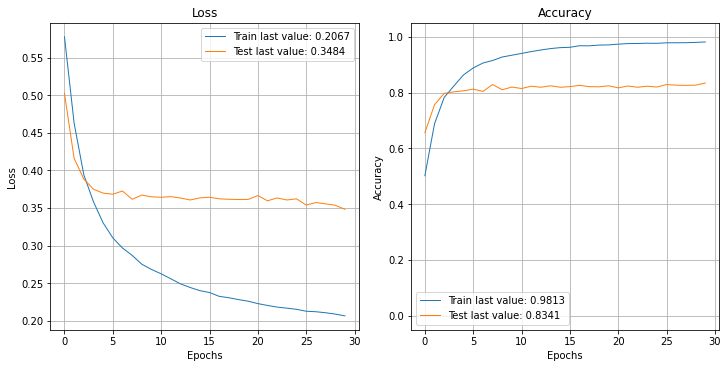

In [ ]:
import matplotlib.pyplot as plt
from plot_keras_history import plot_history

plot_history(history.history, path="1.png")
plot_history(history_2.history, path="2.png")
plt.show()

## Model 3: CNN or LSTM with BERT

Please follow the same methods as model2 to construct a CNN or LSTM model on top of BERT.

In [ ]:
# your code goes here

import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def bert_lstm():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  lstm_sent= LSTM(100, return_sequences=False)(embedded_sent)
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(lstm_sent)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model3_BERT_LSTM')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model3 = bert_lstm()
    optimizer3 = tf.keras.optimizers.Adam(lr=5e-5)
    model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model3 = bert_lstm()
  model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model3.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.179.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.179.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model3_BERT_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_4 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

history_3 = model3.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 115s 3s/step - loss: 0.5881 - accuracy: 0.4864 - val_loss: 0.4901 - val_accuracy: 0.6299
Epoch 2/30
22/22 [==============================] - 6s 291ms/step - loss: 0.4383 - accuracy: 0.6801 - val_loss: 0.3509 - val_accuracy: 0.7733
Epoch 3/30
22/22 [==============================] - 6s 294ms/step - loss: 0.3280 - accuracy: 0.7863 - val_loss: 0.3182 - val_accuracy: 0.7928
Epoch 4/30
22/22 [==============================] - 7s 297ms/step - loss: 0.2703 - accuracy: 0.8321 - val_loss: 0.2966 - val_accuracy: 0.8108
Epoch 5/30
22/22 [==============================] - 6s 290ms/step - loss: 0.2292 - accuracy: 0.8639 - val_loss: 0.2992 - val_accuracy: 0.8168
Epoch 6/30
22/22 [==============================] - 6s 292ms/step - loss: 0.1907 - accuracy: 0.8928 - val_loss: 0.3060 - val_accuracy: 0.8266
Epoch 7/30
22/22 [==============================] - 6s 291ms/step - loss: 0.1572 - accuracy: 0.9159 - val_loss: 0.3218 - val_accuracy: 0.8228
Epoch 8

In [ ]:
results3 = model3.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results3)

42/42 [==============================] - 10s 118ms/step - loss: 0.4638 - accuracy: 0.8391
[0.4638032019138336, 0.8390718698501587]
